# Naive neural network

inputs = (n_inputs, pixel_width, pixel_height, depth) = (1797, 8, 8, 1)
labels = (n_inputs) = (1797,)


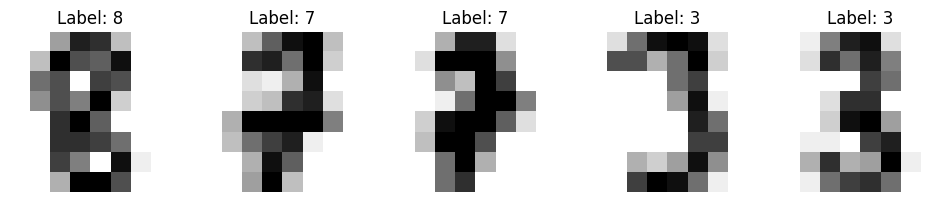

In [11]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our images are grayscale so they should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

### Training the neural network

In [24]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import split and MSELoss. All descent methods.
from Code.utilities import train_test_split, MSELoss_method, plot_test_results, ridge_loss_method
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam

from jax import jit, nn, grad

In [25]:
# Make feature matrix. We flatten each image and use these 64 values as our input layer
X = inputs.reshape((inputs.shape[0], 64))

# Convert the numbers in y to arrays with 0's and 1's corresponding to classes 
y = labels.reshape((labels.shape[0]))
y = np.eye(10)[y]

# Split in test and train
X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=None)

# Make neural network model





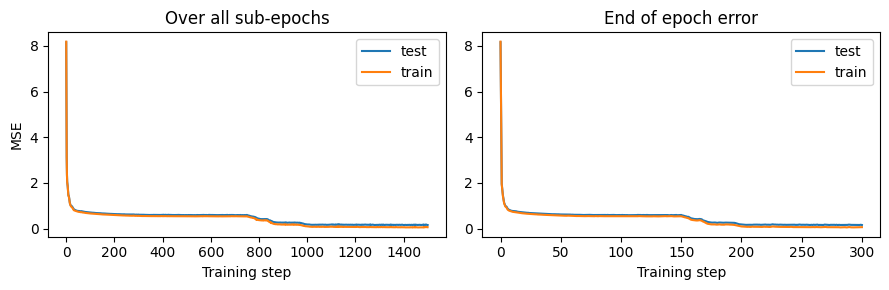

{'train_loss_list': [Array(8.191335, dtype=float32),
  Array(5.1112947, dtype=float32),
  Array(3.0913987, dtype=float32),
  Array(2.351822, dtype=float32),
  Array(2.0143757, dtype=float32),
  Array(1.9395319, dtype=float32),
  Array(1.8630358, dtype=float32),
  Array(1.720458, dtype=float32),
  Array(1.5387864, dtype=float32),
  Array(1.4325927, dtype=float32),
  Array(1.4136469, dtype=float32),
  Array(1.383785, dtype=float32),
  Array(1.3323097, dtype=float32),
  Array(1.2489878, dtype=float32),
  Array(1.1665124, dtype=float32),
  Array(1.1052607, dtype=float32),
  Array(1.0658661, dtype=float32),
  Array(1.0352033, dtype=float32),
  Array(1.0081971, dtype=float32),
  Array(0.9827256, dtype=float32),
  Array(0.9668455, dtype=float32),
  Array(0.958141, dtype=float32),
  Array(0.9515565, dtype=float32),
  Array(0.9436203, dtype=float32),
  Array(0.93305486, dtype=float32),
  Array(0.9173905, dtype=float32),
  Array(0.90213287, dtype=float32),
  Array(0.88689923, dtype=float32),
  A

In [26]:
def single_run(X, z, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, epochs=300, test_index=None, plot_or_not=False):
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [y.shape[1]]
    beta0 = _beta_init(layer_list)

    # Create model
    model = jit(get_neural_network_model(hidden_layer_num ,activation=hidden_activation))

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(ridge_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # MSE loss function for training
    test_func = jit(MSELoss_method(model))

    # Split the dataset.
    X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2, test_index=test_index)

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)
    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], 5, ylabel="MSE")


    return result

single_run(X, y, lr=0.01, lam=0.0001, hidden_layer_num=1, node_per_hidden=20, 
           hidden_activation=nn.sigmoid, epochs=300, test_index=test_index, plot_or_not=True)